In [4]:
using Gadfly;
using Images;

In [12]:
SamplePoints = 100;
SampleSize = 28;
SampleNoise = 100*rand();

In [11]:
x  = SampleSize*rand(Float32, SamplePoints)
#x = convert(Array{Float32,1}, linspace(-0.01, 109.99, 1000))
y0 = x.*x;
y  = y0 + SampleNoise*convert(Array{Float32,1}, randn(SamplePoints));

function discretizeVector(vector::Array{Float32,1}, bins::Int)
    """ Change each value in vector to one of 1:bins """
    vectorInterval = maximum(vector) - minimum(vector)
    vectorInRange = vector - minimum(vector)
    vectorInRange = vector/vectorInterval*bins
    try
        vectorDiscrete = ceil(Uint32, vectorInRange)
      return vectorDiscrete
    catch rounding
      println(minimum(vectorInRange), ' ', maximum(vectorInRange))
      return ones(Uint32, bins)
    end
end


function pointsToMatrix(x::Array{Float32,1}, y::Array{Float32,1})
    xDiscrete = DiscretizeVector(x, SampleSize);
    yDiscrete = DiscretizeVector(y, SampleSize);
    SampleSpace = zeros(Uint16, SampleSize, SampleSize);
    for i = 1:SamplePoints
        SampleSpace[xDiscrete[i], yDiscrete[i]]+= 1;
    end
    return SampleSpace
end

image = sc(grayim(pointsToMatrix(x , y)))

LoadError: SampleSize not defined
while loading In[11], in expression starting on line 1

In [87]:
triangleWave(x) = abs(mod(x, 4)-2)-1

triangleWave (generic function with 1 method)

In [90]:
# Parameters of model generation
ModelComplexity = 5                 # Recursion depth for model generation
Ops = [:+, :-, :.*]                 # Operators used to generate model
ModelNumbers = 10*convert(Float32, randn()) # Numbers used in generation
coordinateSystems = Function[       # Array of coordiante system converions
    (c1, c2)->(c1, c2)                    # Cartesian coordinates
    (c1, c2)->(c1.*cos(c2), c1.*sin(c2))  # Polar coordinates
    (c1, c2)->
    (c1.*triangleWave(c2), c1.*triangleWave(c2-1))
]



function getLabel(y0, y)
  """ Simple 1-R^2, y0 is from model, y is the data """
  SSres = sum((y-y0).^2)
  SStot = sum((y-mean(y)).^2)
  return SSres/SStot
end

# Helper function for model(x, j)
numberOrX(x) = randbool() ? x : ModelNumbers

function model(x, j)
  """ Recursive function that generates expressions from:
  - operators
  - input vector x
  - random numbers """
  if j < ModelComplexity
      return Expr(:call, Ops[rand(1:size(Ops, 1))], numberOrX(x), model(x, j+1))
  else
      return x
  end
end

function sampleModel(SamplePoints::Int)
  """ Sample points from the model """
  coordinate1 = 2*pi*rand(Float32, SamplePoints)
  coordinate2 = eval(model(coordinate1, 0))
  return coordinateSystems[rand(1:end)](coordinate1, coordinate2)
end

function getSample(SamplePoints::Int, SampleSize::Int, SampleNoise)
  """ Generate data using generated model and apply gaussian noise """
  x, y0 = sampleModel(SamplePoints)  # Generates model and evaluates it
  y  = y0 + SampleNoise*convert(Array{Float32,1}, randn(SamplePoints))
  label = getLabel(y0,y)
  return x, y, label
end

getSample (generic function with 1 method)

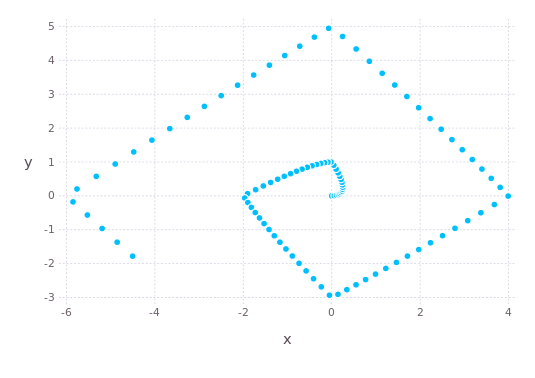

In [101]:
x,y = getSample(SamplePoints::Int, SampleSize::Int, SampleNoise)
c1 = linspace(0, 2*pi)
c2 = c1
x, y = coordinateSystems[3](c1, c2)
plot(x=x, y=y)

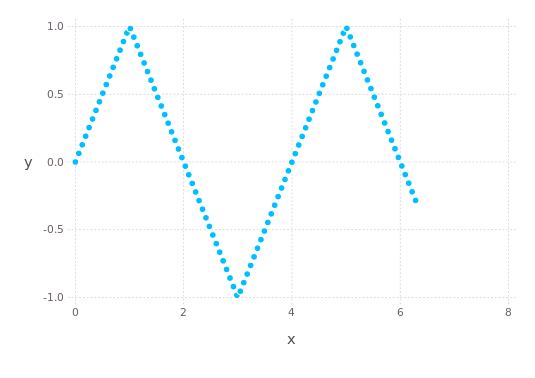

In [89]:
plot(x=c1, y=triangleWave(c1-1))

In [86]:
help(mod)

Base.mod(x, m)

   Modulus after division, returning in the range [0,m).
